**NOTE: THIS ONLY USES 1 LABEL, WHICH IS OBVIOUSLY NOT MULTI-CLASSIFICATION.**

Libraries to import.

In [80]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from collections import defaultdict
from collections import Counter 

plt.style.use('ggplot')
STOP_WORDS = set(stopwords.words('english'))

import re
import csv
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

Loading the data and some pre-cleaning.

In [81]:
from ftfy import fix_encoding

def fix_encode(x):
    return fix_encoding(x)

In [82]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

data = pd.read_csv(
    "datasets/mc-dataset-1.csv",
    encoding="utf-8",
    header=0,
    delimiter=";",
    quoting=csv.QUOTE_ALL
)

data = data.fillna(0)

CONVERT_DICT={
    'text': str,
    'env_problems': int,
    'pollution': int,
    'treatment': int,
    'climate': int, 
    'biomonitoring': int
}

data=data.astype(CONVERT_DICT)

data['text'] = data['text'].apply(lambda x: fix_encode(x))

In [ ]:
# FOR testing purposes only
# data.head(5)

In [83]:
# take env_problems only
target_name = 'env_problems'
name_for_plot = 'environmental_problems'
data = data[['text', target_name]]
data.columns = ['text', 'target']
data.head(5)

,text,target
0,In the Southern Bug basin wastewater is discharged from 341 organized sources (Map 5). In 2011 (reference year) 211 mln. m3 was discharged in total.,1
1,This amount is distributed as follows: urban and rural housing wastewater treatment facilities (WWTPs - vodocanals) – 70 mln. m3 (57 users) industry – 50 mln. m3 (79 users) agriculture – 90 mln. m3 (193 users) other users – 1 mln. m3 (12 users) (Picture. 2.1).,1
2,Despite the similar volumes of discharged wastewater major part of pollutants comes with communal WWTPs.,1
3,They bring 84% of organic pollution 86% of phosphate ions and 84% of mineral nitrogen 91% of ammonia nitrogen 87% nitrate nitrogen and 79% nitrite nitrogen.,1
4,The input of the industry is between 7–21% and agriculture has the lowest impact on water bodies - 0–6%. Of the 92 urban areas only 51 localities (55%) have centralized collection of communal waste waters and their monitoring. Among the 2878 villages 6 of them (0.2%) have such a monitoring.,1


Train-test split.

In [84]:
train, test = train_test_split(data, test_size=0.4, shuffle=True, random_state=91)

train_base = train.copy()
train_target = train_base['target']

test_base = test.copy()
test_target = test_base['target']

In [85]:
print(data.shape)
print(train.shape)
print(test.shape)

(100, 2)
(60, 2)
(40, 2)


Exploring the class distribution.

In [86]:
# extracting the number of examples of each class
REAL_len = data[data['target'] == 1].shape[0]
NOT_REAL_len = data[data['target'] == 0].shape[0]

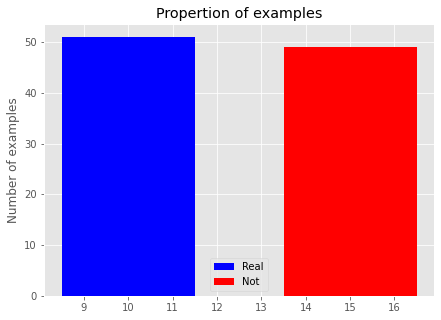

In [87]:
# bar plot of the 3 classes
plt.rcParams['figure.figsize'] = (7, 5)
plt.bar(10,REAL_len,3, label="Real", color='blue')
plt.bar(15,NOT_REAL_len,3, label="Not", color='red')
plt.legend()
plt.ylabel('Number of examples')
plt.title('Propertion of examples')
plt.show()

In [88]:
def length(text):
    return len(text)

In [89]:
data['text_length'] = data['text'].apply(length)

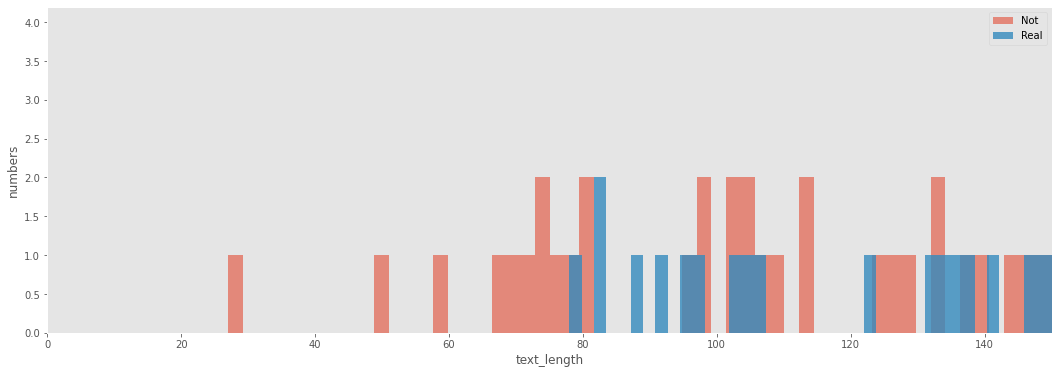

In [90]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(data[data['target'] == 0]['text_length'], alpha = 0.6, bins=bins, label='Not')
plt.hist(data[data['target'] == 1]['text_length'], alpha = 0.8, bins=bins, label='Real')
plt.xlabel('text_length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

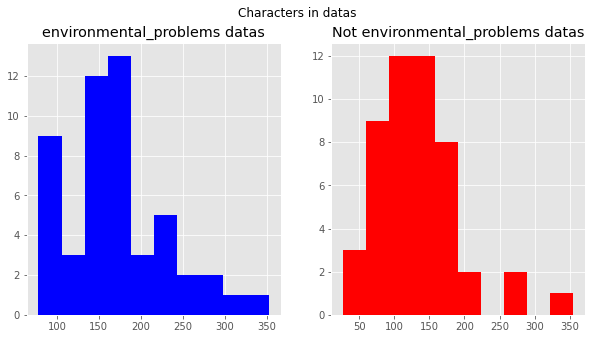

In [91]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=data[data['target']==1]['text'].str.len()
ax1.hist(data_len,color='blue')
ax1.set_title(f'{name_for_plot} datas')
data_len=data[data['target']==0]['text'].str.len()
ax2.hist(data_len,color='red')
ax2.set_title(f'Not {name_for_plot} datas')
fig.suptitle('Characters in datas')
plt.show()

The distributions are different. 150 characters in a data are the one of the most common among both.

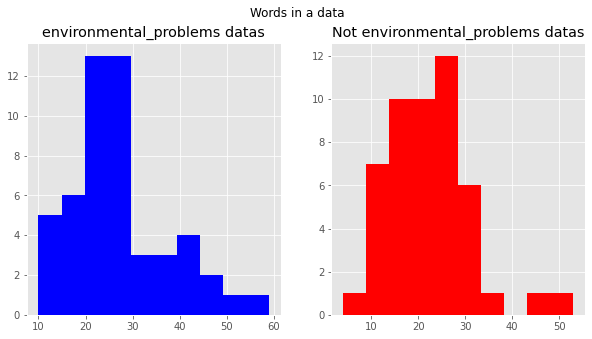

In [92]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
data_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(data_len,color='blue')
ax1.set_title(f'{name_for_plot} datas')
data_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(data_len,color='red')
ax2.set_title(f'Not {name_for_plot} datas')
fig.suptitle('Words in a data')
plt.show()

Text(0.5, 0.98, 'Average word length in each data')

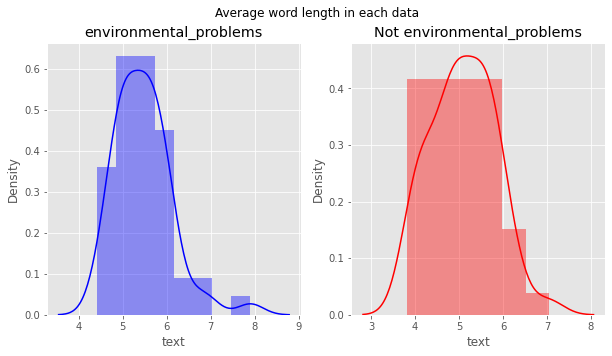

In [93]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=data[data['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='blue')
ax1.set_title(name_for_plot)
word=data[data['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='red')
ax2.set_title(f'Not {name_for_plot}')
fig.suptitle('Average word length in each data')

In [97]:
def create_corpus(target):
    corpus = []

    for x in data[data['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [114]:
def create_corpus_df(data, target):
    corpus=[]
    
    for x in data[data['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

common stopwords in data

In [115]:
corpus = create_corpus(0)

dic = defaultdict(int)
for word in corpus:
    if word in STOP_WORDS:
        dic[word]+=1

top = sorted(dic.items(), key= lambda x:x[1], reverse=True)[:10]

#display the stopwords
np.array(STOP_WORDS)

array({"that'll", 'them', 'he', 'mightn', 'which', 'to', 'yours', 'all', 'have', 'from', "weren't", 'those', 'it', "it's", 'weren', 'our', 'into', 'themselves', 'nor', 'didn', 'my', "won't", "aren't", 'yourself', 'where', 'more', 'me', 'at', 'who', 'they', "shan't", 'by', 'been', 'there', 'm', 'mustn', 'not', 'before', "doesn't", 'aren', 'any', 'their', 'an', "haven't", 'having', 'very', 'out', "isn't", 'you', 'herself', 'against', 'has', "shouldn't", 'up', 'what', 'why', 'if', "don't", 'had', 'hers', 'did', 'most', "wasn't", "wouldn't", 'should', 'your', 'through', "you'd", 'as', "she's", 'once', 'with', 'ma', "hadn't", "needn't", 're', 'such', 'and', 'but', 'this', 'over', 'just', 'can', 'a', 'am', 'be', 'same', 'than', 'are', 've', 'other', "didn't", 'his', 'was', 'the', 'in', "mightn't", 's', 'y', 'himself', 'don', 'is', 'for', 'above', 'while', 'until', 'itself', 'her', 'further', 'shouldn', 'only', 'won', 'she', 'down', 'few', 'own', 'yourselves', 'i', 'whom', 'when', 'below', 'w

<BarContainer object of 10 artists>

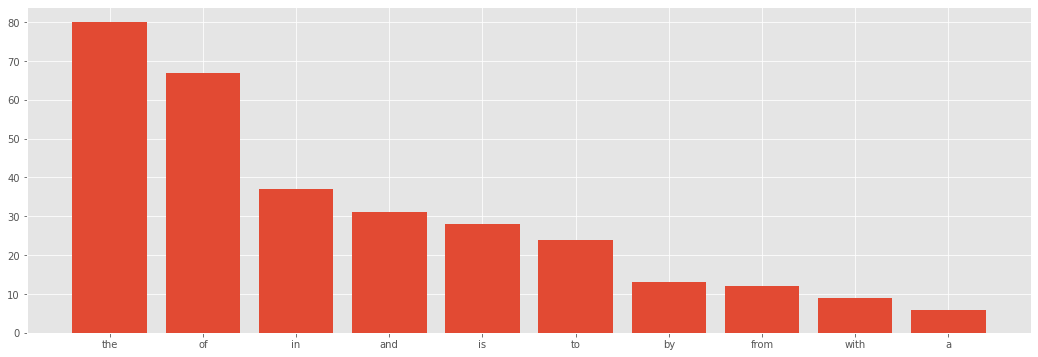

In [99]:
plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

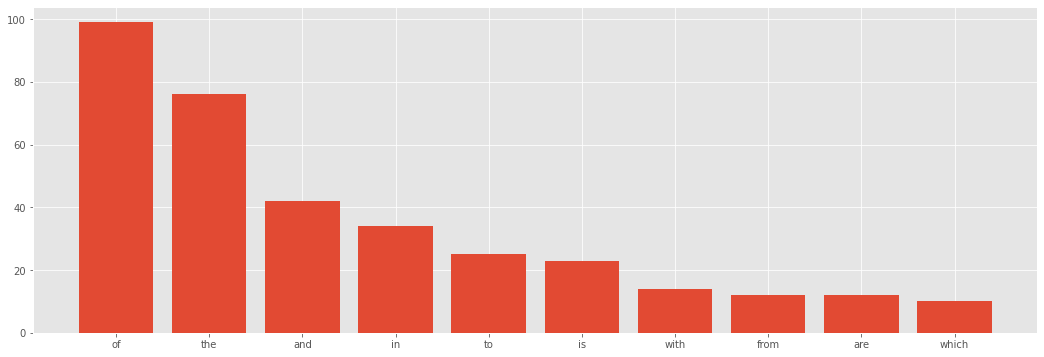

In [100]:
corpus=create_corpus(1)

dic=defaultdict(int)
for word in corpus:
    if word in STOP_WORDS:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    

plt.rcParams['figure.figsize'] = (18.0, 6.0)
x,y=zip(*top)
plt.bar(x,y)

In both of them,"of" and "the" dominates which are followed by "in" in class 0 and "and" in class 1.

Punctuation.

<BarContainer object of 5 artists>

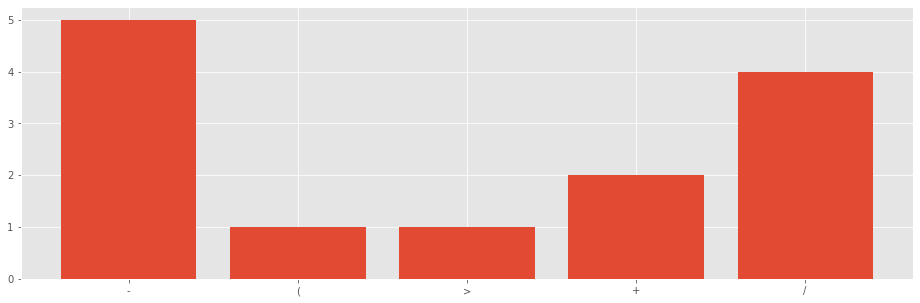

In [101]:
plt.figure(figsize=(16,5))
corpus=create_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y)

<BarContainer object of 1 artists>

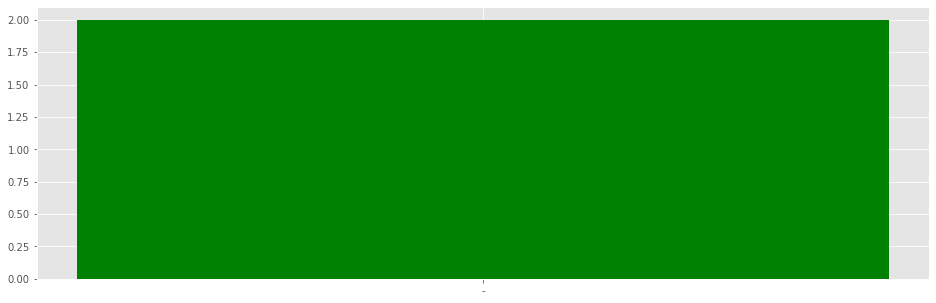

In [102]:
plt.figure(figsize=(16,5))
corpus=create_corpus(0)
dic=defaultdict(int)
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='green')

Common words.

In [103]:
plt.figure(figsize=(16, 5))
counter = Counter(corpus)

most = counter.most_common()
x = []
y = []

for word, count in most[:50]:
    if (word not in STOP_WORDS):
        x.append(word)
        y.append(count)

<Figure size 1152x360 with 0 Axes>

<AxesSubplot:>

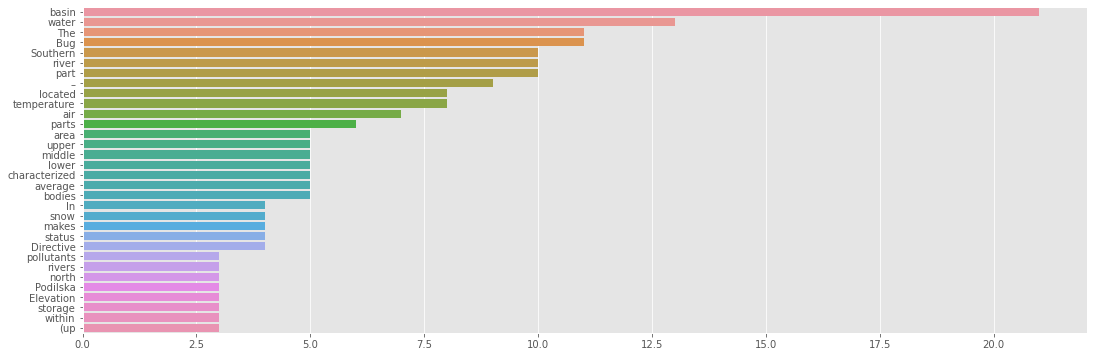

In [104]:
sns.barplot(x=y, y=x)

in other words, need to do data cleaning.

In [105]:
def get_top_data_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

<AxesSubplot:>

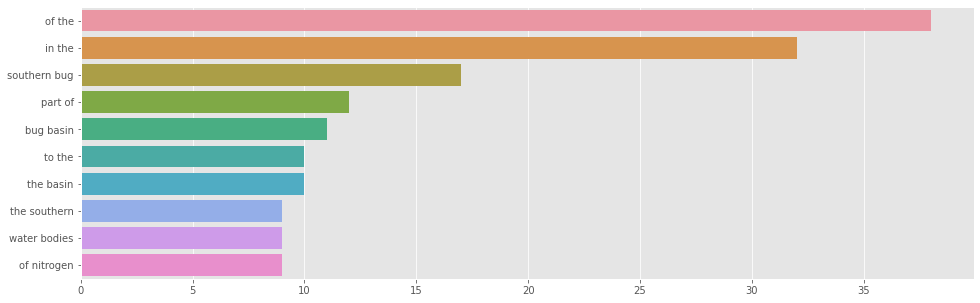

In [106]:
plt.figure(figsize=(16,5))
top_data_bigrams=get_top_data_bigrams(data['text'])[:10]
x,y=map(list,zip(*top_data_bigrams))
sns.barplot(x=y,y=x)

# Data Cleaning

In [107]:
df = pd.concat([train, test])

df.shape

(100, 2)

In [109]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

df['text']=df['text'].apply(lambda x : remove_URL(x))
df['text']=df['text'].apply(lambda x : remove_html(x))
df['text']=df['text'].apply(lambda x : remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [110]:
ABBREV_LIST={
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life redata", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "redata",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "data me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [111]:
def clean_datas_remove_URL(text):
    text = ''.join([x for x in text if x in string.printable])

    text = re.sub(r"http\S+", "", text)
    return text

def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def strip_punctuation(text):
    PUNCTUATIONS_LIST = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"

    for p in PUNCTUATIONS_LIST:
        text = text.replace(p, f' {p} ')
    
    text = text.replace('...', ' ... ')
    if '...' not in text:
        text = text.replace('..', ' ... ')

    return text

    # table = str.maketrans('','',string.punctuation)
    # return text.translate(table)

def convert_abbreviations(word):
    return ABBREV_LIST[word.lower()] if word.lower() in ABBREV_LIST.keys() else word

def convert_text_abbreviations(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbreviations(word) in tokens]
    text = ' '.join(tokens)
    return text

In [112]:
def data_cleaning(df):
    df['text'] = df['text'].apply(lambda x: clean_datas_remove_URL(x))
    df["text"] = df["text"].apply(lambda x: remove_emojis(x))
    df['text'] = df['text'].apply(lambda x: strip_punctuation(x))
    df['text'] = df['text'].apply(lambda x: convert_text_abbreviations(x))
    return df

In [ ]:
TARGET_BIG_CORRECTED = True

if TARGET_BIG_CORRECTED:
    train = data_cleaning(train)
    test = data_cleaning(test)
    data = data_cleaning(data)

In [116]:
corpus_new1 = create_corpus_df(df, 1)
len(corpus_new1)

1365

In [120]:
corpus_new1[:5]

['This', 'leads', 'to', 'balance', 'destruction']

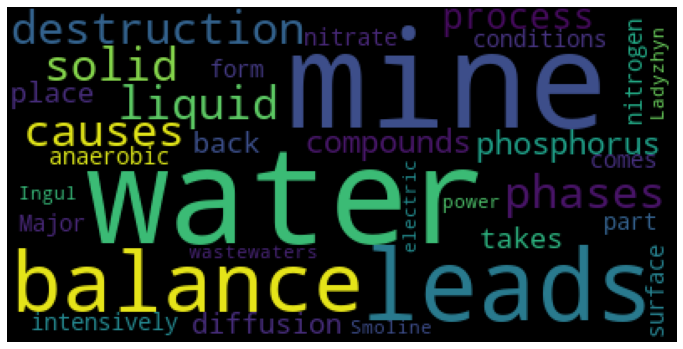

In [121]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new1[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [123]:
# target = 0
corpus_new0 = create_corpus_df(df, 0)
len(corpus_new0)

corpus_new0[:5]

['Average', 'annual', 'air', 'temperature', 'varies']

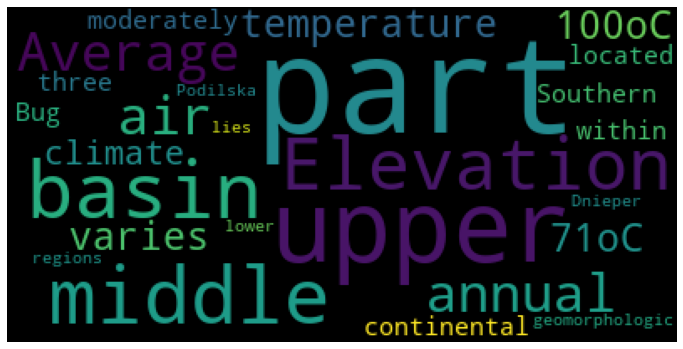

In [124]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_new0[:50]))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

In [125]:
df.head(10)

,text,target
38,This leads to balance destruction between solid and liquid phases and causes the process of phosphorus compounds diffusion back into the water which takes place intensively in anaerobic conditions,1
72,Average annual air temperature varies from 71oC to 100oC,0
69,In the upper and middle parts of the basin the climate is moderately continental,0
64,Southern Bug basin is located within three geomorphologic regions its upper part lies on Podilska Elevation middle part – on Dnieper Elevation and lower part – on BlackSea Lowland,0
48,Major part of nitrogen in nitrate form comes into surface waters with wastewaters of Ingul mine Smoline mine Ladyzhyn electric power station “BOS” in Voznesensk Picture 214,1
31,Based on this the conclusion was done that at the first part the increase of the concentrations of mineral nitrogen is caused by entering of significant number of wastewaters into the river,1
15,This method allows extracting only a part of pollutants containing nitrogen and phosphorus,1
76,The average snow cover height is 10 to 15 cm In some years winter can be longlasting and severe,0
98,Use of these values was offered by the Monitoring Expert Group of the International Commission for the Protection of Danube River ICPDR and is determined in the Directive 200990EU,0
55,Its basin borders with Dnister river in the west and with Dnipro river – in the north and in the east,0


In [130]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

In [127]:
X_train = train['text'].tolist()
y_train = train['target'].tolist()
X_train_counts, count_vectorizer = cv(X_train)

X_test = test['text'].tolist()
y_test = test['target'].tolist()
X_test_counts = count_vectorizer.transform(X_test)

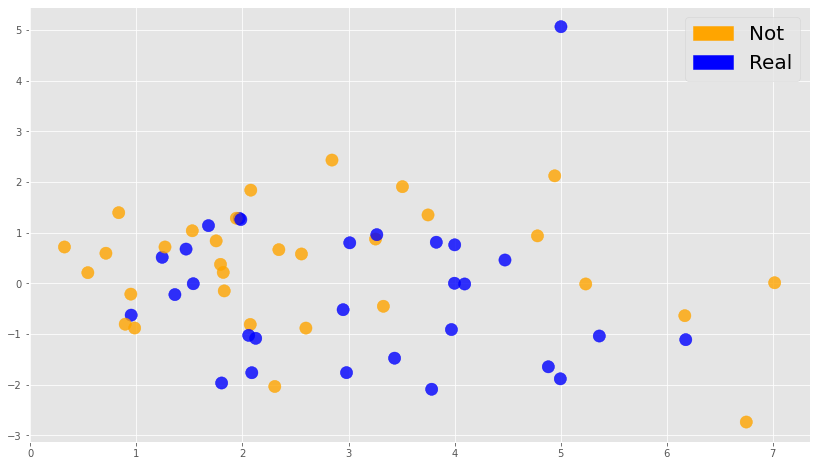

In [128]:
def plot_LSA(test_data, test_labels, savepath='PCA_demo.csv', plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['orange','blue']
    if plot:
        plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=150, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
        orange_patch = mpatches.Patch(color='orange', label='Not')
        blue_patch = mpatches.Patch(color='blue', label='Real')
        plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

fig = plt.figure(figsize=(14, 8))
plot_LSA(X_train_counts, y_train)
plt.show()

Not cleanly separated. Consider Tfidf.

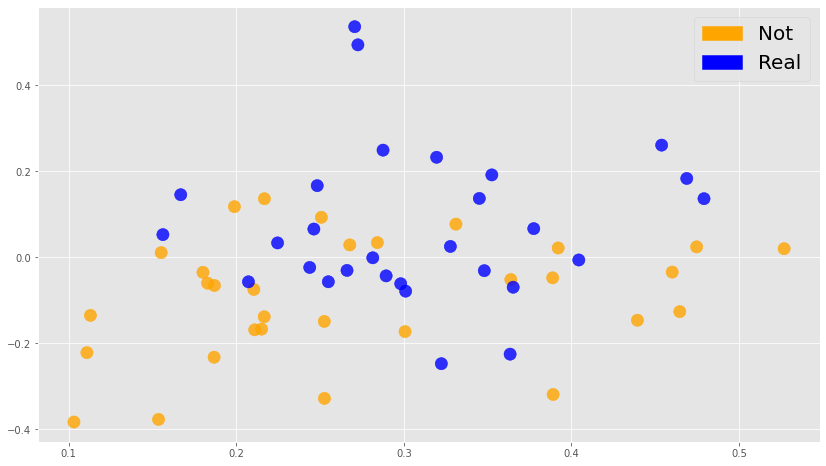

In [132]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(14, 8))
plot_LSA(X_train_tfidf, y_train)
plt.show()

# GloVe